In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import statsmodels
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

!apt-get update -qq
!apt-get install fonts-nanum* -qq


%matplotlib inline
warnings.filterwarnings("ignore")

Selecting previously unselected package fonts-nanum.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm._rebuild()
plt.rc('font', family='NanumGothic')

In [23]:
df = pd.read_csv("/content/funda_train.csv", encoding="utf-8")

In [24]:
df

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000
...,...,...,...,...,...,...,...,...,...
1545066,553,1066405,c,2018-05-22,19:57,0,경기 수원시,한식 음식점업,2714.285714
1545067,553,1065438,g,2018-05-22,20:03,0,경기 수원시,한식 음식점업,4142.857143
1545068,553,1068539,c,2018-05-22,20:59,0,경기 수원시,한식 음식점업,2571.428571
1545069,553,1067557,a,2018-05-22,21:15,0,경기 수원시,한식 음식점업,3714.285714


installment_term = 할부 개월 수


# 전처리 

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


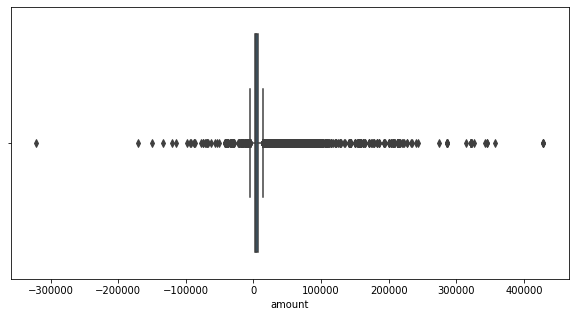

In [4]:
# 1. 이상치 제거 (환불)
df[df['amount']<0]

# 이상치 확인
plt.figure(figsize=(10, 5))
sns.boxplot(df['amount'])

In [25]:
df['datetime'] = df['transacted_date'] + " " + df['transacted_time']
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")

In [26]:
# 환불 거래 제거 함수
def remove_refund(df):
  refund = df[df['amount']<0]
  non_refund = df[df['amount']>0]
  remove_data = pd.DataFrame()
  for i in tqdm(df.store_id.unique()):
    divided_data = non_refund[non_refund['store_id']==i]
    divided_data2 = refund[refund['store_id']==i]

    for neg in divided_data2.to_records()[:]:
      refund_store = neg['store_id']
      refund_id = neg['card_id']
      refund_datetime = neg['datetime']
      refund_amount = abs(neg['amount']) 

      # 환불 시간 이전의 데이터 중 카드 아이디와 환불액이 동일한 리스트
      refund_pay_list = divided_data[divided_data['datetime']<=refund_datetime]
      refund_pay_list = refund_pay_list[refund_pay_list['card_id']==refund_id]
      refund_pay_list = refund_pay_list[refund_pay_list['amount']==refund_amount]

      if len(refund_pay_list) !=0:
        refund_datetime = max(refund_pay_list['datetime'])
        noise_list = divided_data[divided_data['datetime']==refund_datetime]
        noise_list = noise_list[noise_list['card_id']==refund_id]
        noise_list = noise_list[noise_list['amount']==refund_amount]
        divided_data = divided_data.drop(index=noise_list.index)
    
    remove_data = pd.concat([remove_data, divided_data], axis=0)
  return remove_data 




100%|██████████| 516/516 [01:53<00:00,  4.56it/s]


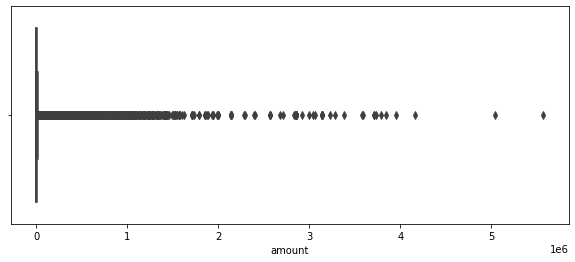

In [27]:
positive_data = remove_refund(df)

plt.figure(figsize=(10, 4))
sns.boxplot(positive_data['amount'])

In [28]:
positive_data

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,datetime
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016-06-02 11:06:00
...,...,...,...,...,...,...,...,...,...,...
1545066,553,1066405,c,2018-05-22,19:57,0,경기 수원시,한식 음식점업,2714.285714,2018-05-22 19:57:00
1545067,553,1065438,g,2018-05-22,20:03,0,경기 수원시,한식 음식점업,4142.857143,2018-05-22 20:03:00
1545068,553,1068539,c,2018-05-22,20:59,0,경기 수원시,한식 음식점업,2571.428571,2018-05-22 20:59:00
1545069,553,1067557,a,2018-05-22,21:15,0,경기 수원시,한식 음식점업,3714.285714,2018-05-22 21:15:00


<BarContainer object of 10 artists>

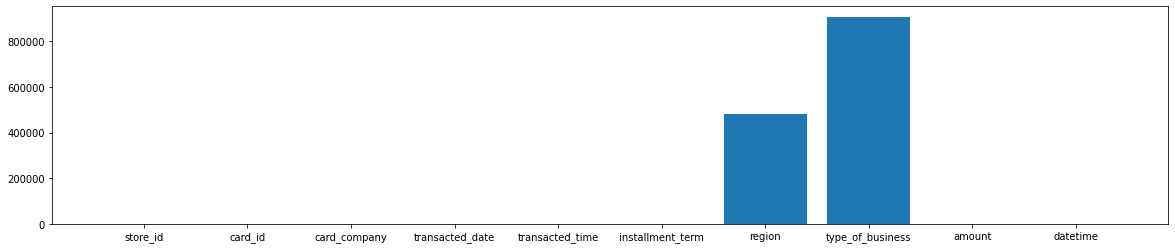

In [29]:
# 2. 결측치 확인

plt.figure(figsize=(20,4))
plt.bar(df.columns, df.isnull().sum())

지역과 업종 속성에서 결측치 존재

In [30]:
positive_data.drop(['region', 'type_of_business'], axis=1, inplace=True)

In [31]:
positive_data

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00
...,...,...,...,...,...,...,...,...
1545066,553,1066405,c,2018-05-22,19:57,0,2714.285714,2018-05-22 19:57:00
1545067,553,1065438,g,2018-05-22,20:03,0,4142.857143,2018-05-22 20:03:00
1545068,553,1068539,c,2018-05-22,20:59,0,2571.428571,2018-05-22 20:59:00
1545069,553,1067557,a,2018-05-22,21:15,0,3714.285714,2018-05-22 21:15:00


In [35]:
# 3. 다운 샘플링

## 월 단위 다운 샘플링 함수를 정의
def month_resampling(data):
    new_data = pd.DataFrame() 
    # 년도와 월을 합친 변수를 생성합니다.
    df['year_month'] = df['transacted_date'].str.slice(stop=7)
    # 데이터의 전체 기간을 추출합니다.
    year_month = df['year_month'].drop_duplicates()
    # 상점 아이디별로 월 단위 매출액 총합을 구합니다.
    downsampling_data = df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data = pd.DataFrame(downsampling_data)
    downsampling_data = downsampling_data.reset_index(drop=False,inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        # 상점별로 데이터를 처리합니다.
        store = downsampling_data[downsampling_data['store_id']==i]
        # 각 상점의 처음 매출이 발생한 월을 구합니다.
        start_time = min(store['year_month'])
        # 모든 상점을 전체 기간 데이터로 만듭니다.
        store = store.merge(year_month,how='outer')
        # 데이터를 시간순으로 정렬합니다.
        store = store.sort_values(by=['year_month'], axis=0, ascending=True) 
        store['amount'] = store['amount'].fillna(2)   # 매출이 발생하지 않는 월은 2로 채웁니다.
        store['store_id'] = store['store_id'].fillna(i)  # 상점 아이디 결측치를 채웁니다.
        store = store[store['year_month']>=start_time]  # 처음 매출이 발생한 월 이후만 뽑습니다.
        
        new_data = pd.concat([new_data,store],axis=0)
        
    return new_data

In [39]:
resample_data = month_resampling(positive_data)

resample_data['store_id'] = resample_data['store_id'].astype(int)
resample_data

# resample_data

100%|██████████| 516/516 [00:04<00:00, 127.32it/s]


,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.715714e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
28,553,2018-10,2.000000e+00
29,553,2018-11,2.000000e+00
30,553,2018-12,2.000000e+00
31,553,2019-01,2.000000e+00


In [40]:
resample_data.to_csv("/resample_data.csv")

# 시리즈 객체 변환
- 시계열 분석을 위해서 필요

In [57]:
# df -> series

def time_series(df, i):
    # 상점별로 데이터를 뽑습니다.
    store = df[df['store_id']==i]
    ## 날짜 지정 범위는 영업 시작 월부터 2019년 3월 전까지 영업 마감일 기준
    index = pd.date_range(min(store['year_month']),'2019-03',freq='BM') 
    ## 시리즈 객체로 변환
    ts = pd.Series(store['amount'].values,index=index)
    return ts

In [ ]:
store_3 = resample_data[resample_data['store_id'] == 3]
store_3

resample_data['store_id'].unique() # 3, 21

NameError: ignored

# 탐색적 데이터 분석

1. date별 amount: month 별로 차이가 있을 것
2. 사업종별 amount: 사업 별로 amount 차이가 있을 것
3. time별 amount 차이: 시간 별로 
4. 사업종과 time의 상관성
5. 사업과 할부개월수의 상관성

In [ ]:
df.dtypes

store_id              int64
card_id               int64
card_company         object
transacted_date      object
transacted_time      object
installment_term    float64
region               object
type_of_business     object
amount              float64
dtype: object

In [ ]:
df['transacted_time'] = df['transacted_time'].str.slice(stop=2)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


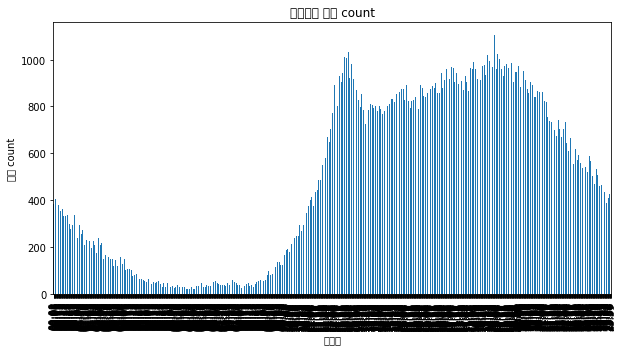

In [ ]:
df['transacted_time'].value_counts()

plt.figure(figsize=(10,5))
df['transacted_time'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel('시간대')
plt.ylabel('결제 count')
plt.title('시간대별 결제 count')
plt.show() # 캔버스를 보여준다

In [ ]:
df['installment_term'].describe()

count    704502.000000
mean          0.176481
std           1.222767
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          60.000000
Name: installment_term, dtype: float64

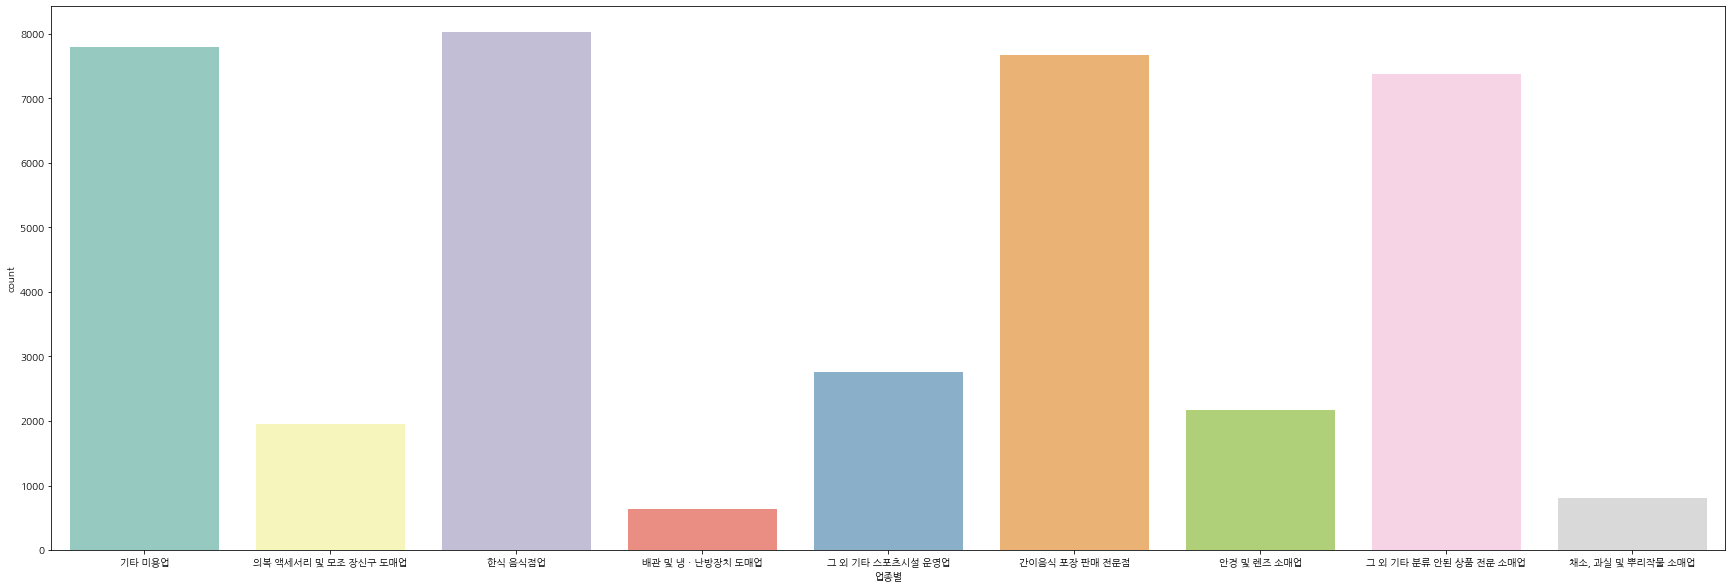

In [ ]:
plt.figure(figsize=(30, 10))


cnt=sns.countplot(x='type_of_business',data=df,palette='Set3')
cnt.set_xlabel("업종별")
cnt.set_ylabel("결제 수")
plt.show()

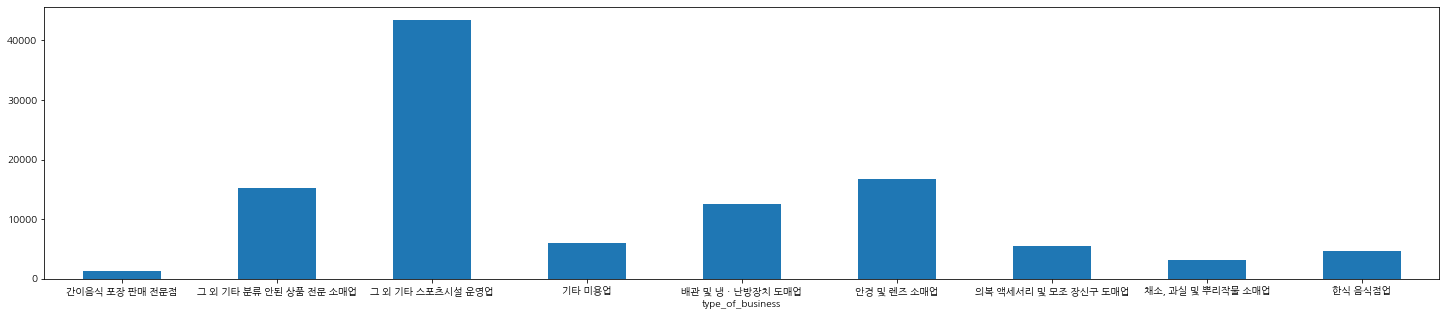

In [ ]:
# 업종별 평균 비용

a = df.groupby(['type_of_business'])['amount'].mean()
a.plot(kind='bar',rot=0,figsize=(25,5))


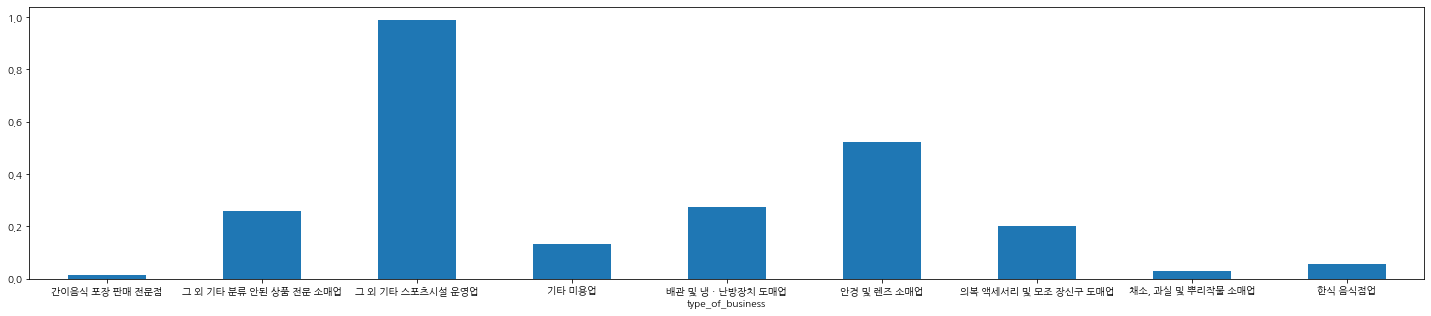

In [ ]:
# 업종별 평균 할부개월수

a = df.groupby(['type_of_business'])['installment_term'].mean()
a.plot(kind='bar',rot=0,figsize=(25,5))

<Figure size 720x360 with 0 Axes>

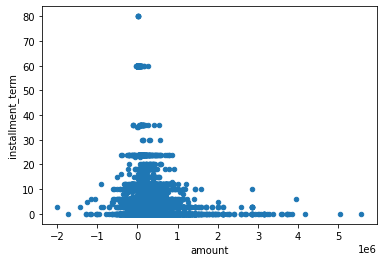

In [ ]:
plt.figure(figsize=(10,5))
df.plot.scatter(x='amount',y='installment_term')
plt.show()


In [ ]:
resample_data

,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
28,234,2018-10,6.430000e+05
29,234,2018-11,1.146571e+05
30,234,2018-12,2.000000e+00
31,234,2019-01,2.000000e+00


In [ ]:
def store_displot(data,start_id,end_id):
    plt.figure(figsize=(15, 6))
    for i in data.store_id.unique()[start_id:end_id]:
        sns.distplot(data[data.store_id == i].amount)
    plt.grid()
    plt.show()

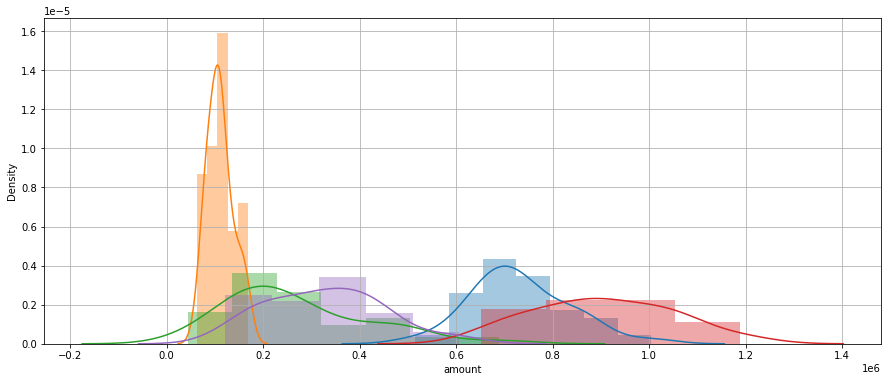

In [ ]:
store_displot(resample_data,0,5)

ValueError: ignored

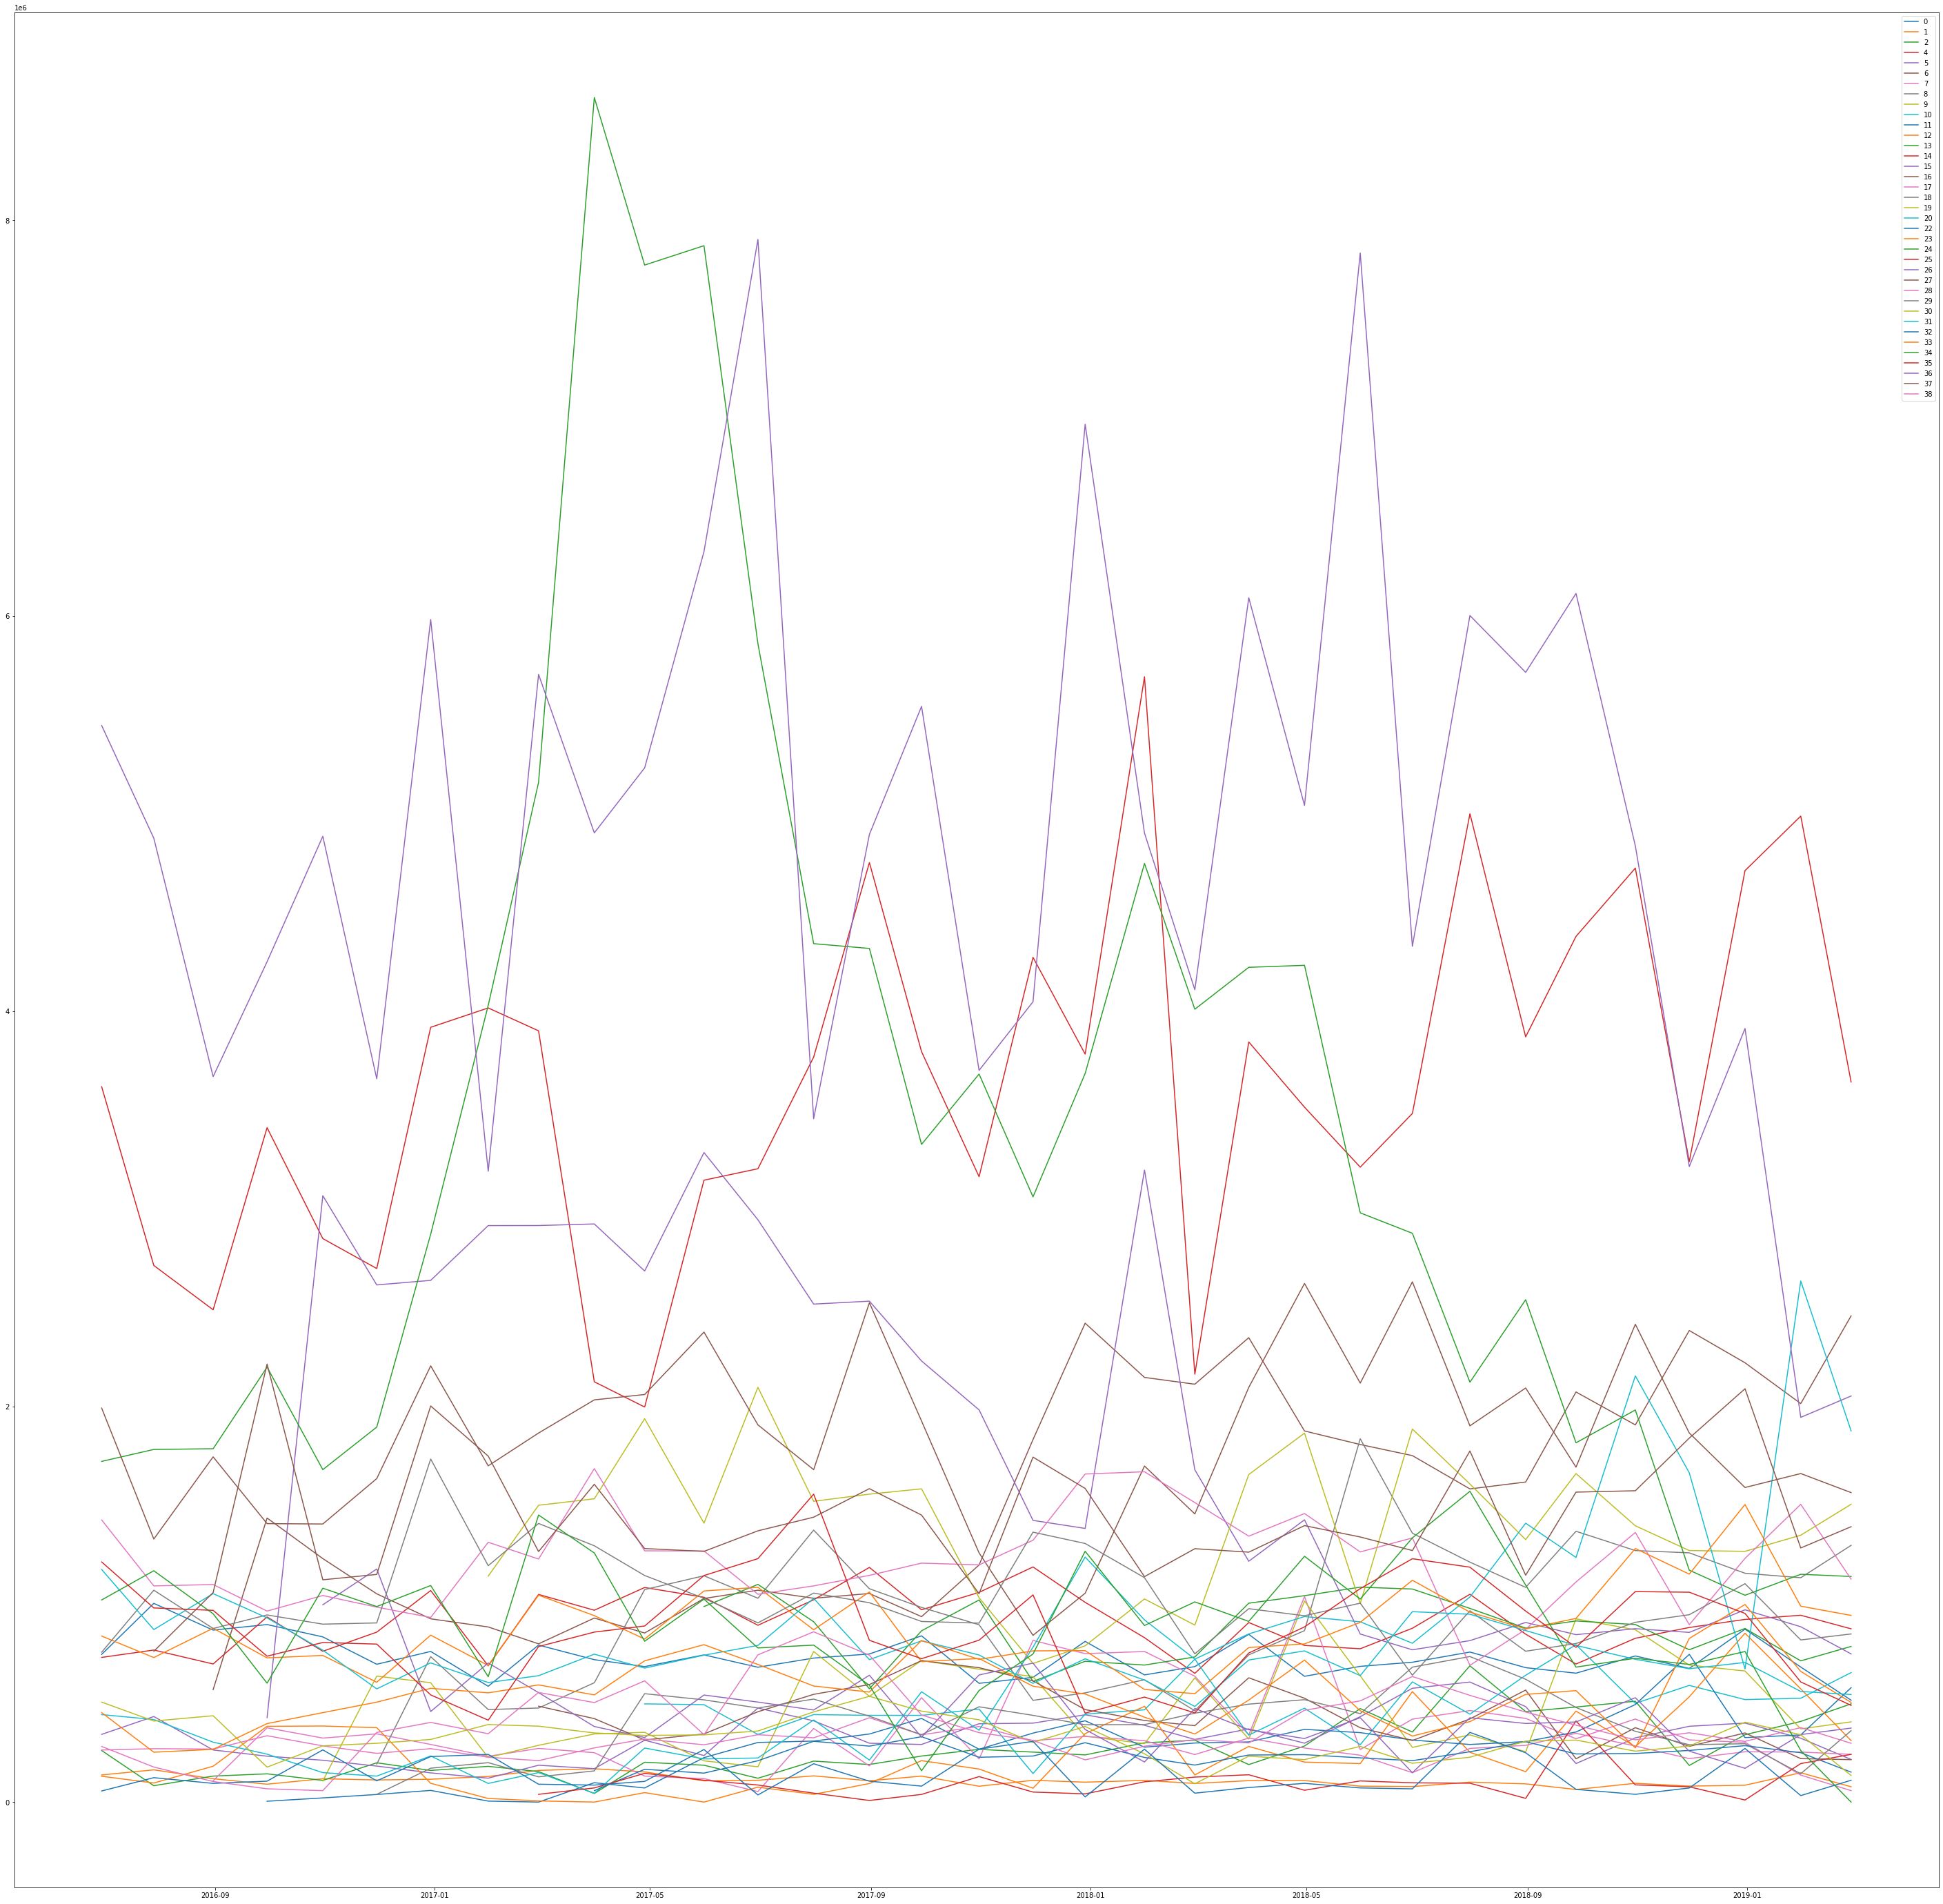

In [ ]:
a = len(resample_data['store_id'].unique())
plt.figure(figsize=(50,50))

for i in range(a+2):
  if (i == 3) | (i == 21):
    pass
  else:
    store = time_series(resample_data, i)
    plt.plot(store, label=i)
    plt.legend()
  
store_plot(resampling_data,0,10)
store_displot(resampling_data,0,5)


# 1. 계절성이 있는 상점을 식별함 : 257, 2096

# 2. 추세가 있는 상점을 식별함 (꾸준히 증가 혹은 꾸준히 감소) : 335, 510

# 3. 휴업 중인 상점 : 111, 279



In [ ]:
a = len(resample_data['store_id'].unique())

plt.figure(figsize=(30,30))

for i in range(a+2):
  if (i == 3) | (i == 21):
    pass
  else:
    store = time_series(resample_data, i)
    plt.plot(store, label=i)
    plt.legend()


# 시계열 데이터의 정상성

In [ ]:
from pmdarima.arima import ADFTest

# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resample_data, 0)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_0)
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : 0.022488 , should_diff : False


In [ ]:
# 상점 아이디가 4번인 데이터를 시리즈 객체로 변환
store_4 = time_series(resample_data, 4)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_4)
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : 0.560046 , should_diff : True


차분 필요함

100%|██████████| 27/27 [00:00<00:00, 220.31it/s]


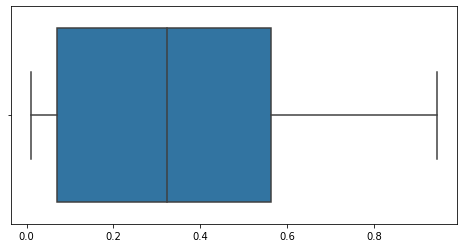

In [ ]:
## ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    return ADFTest().should_diff(y)[0]

adf_p = []
count = 0
skipped = []

for i in tqdm(resample_data['store_id'].unique()):
    ts = time_series(resample_data,i)
    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    except:
        skipped.append(i)

plt.figure(figsize=(8, 4))
sns.boxplot(adf_p)

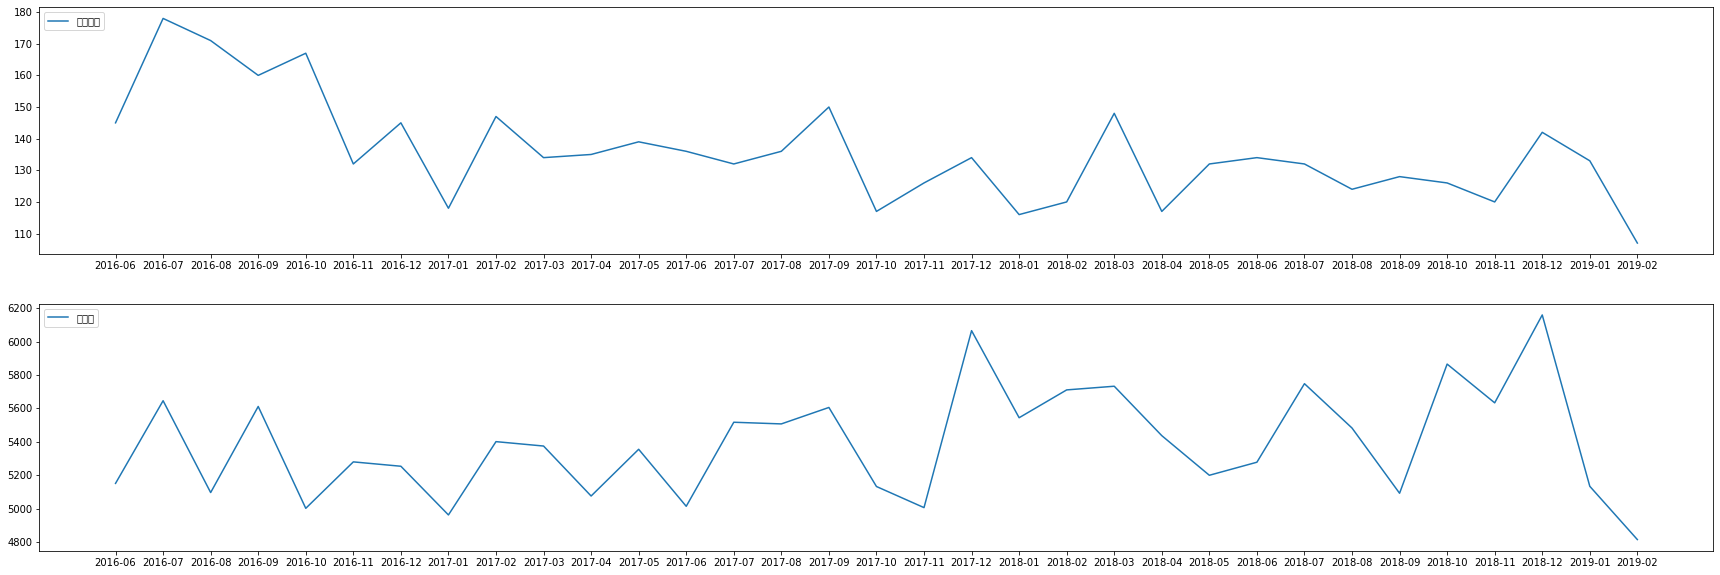

In [ ]:
# 월별 매출 건수와 매출액
fig, ax = plt.subplots(2,1, figsize=(30,10))

store_0_df = df[df['store_id'] == 0]

store_0_df['year_month'] = store_0_df['transacted_date'].str.slice(stop=7)
ax[0].plot(store_0_df.groupby('year_month').size(), label='매출건수')
ax[1].plot(store_0_df.groupby('year_month')['amount'].mean(), label='매출액')
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper left')

year_month
2016-06    5151.724138
2016-07    5646.067416
2016-08    5096.908939
2016-09    5611.607143
2016-10    5002.566296
2016-11    5280.303030
2016-12    5254.187192
2017-01    4963.075061
2017-02    5401.360544
2017-03    5375.053305
2017-04    5076.190476
2017-05    5355.601233
2017-06    5014.705882
2017-07    5517.316017
2017-08    5507.352941
2017-09    5605.714286
2017-10    5133.089133
2017-11    5006.802721
2017-12    6065.031983
2018-01    5544.334975
2018-02    5710.714286
2018-03    5732.625483
2018-04    5437.118437
2018-05    5200.216450
2018-06    5278.251599
2018-07    5747.835498
2018-08    5482.718894
2018-09    5092.633929
2018-10    5865.079365
2018-11    5633.333333
2018-12    6158.953722
2019-01    5134.264232
2019-02    4815.754339
Name: amount, dtype: float64

# 모델링

In [43]:
resample_df = pd.read_csv("/resample_data.csv")

In [ ]:
# R 패키지와 파이썬 연동

from rpy2.robjects.packages import importr

utils = importr('utils') # utils 패키지를 임포트
utils.install_packages('forecast') # r의 forecast 패키지 설치.
utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치

In [48]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

store_0 = resample_df[resample_df['store_id']==0]
start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월
    
# R의 ts 함수로 r의 time series 자료형으로 변환
train = ts(store_0['amount'], start=c(start_year, start_month), frequency=12) 

#ensemble model
forecast = auto_arima(train)
np.sum(ro.conversion.rpy2py(forecast).values) # 3개월 매출을 합산

2006844.622859887

In [50]:
len(train)

33

https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

In [46]:
print(dir(pandas2ri))

['BoolVector', 'DataFrame', 'DateVector', 'FactorVector', 'FloatSexpVector', 'ISOdatetime', 'IntSexpVector', 'IntVector', 'ListSexpVector', 'OrderedDict', 'POSIXct', 'PandasDataFrame', 'Sexp', 'SexpVector', 'StrSexpVector', 'StrVector', '_PANDASTYPE2RPY2', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', '_int_populate_r_vector', '_str_populate_r_vector', 'activate', 'as_vector', 'conversion', 'converter', 'datetime', 'deactivate', 'dt_O_type', 'functools', 'integer_array_types', 'is_datetime64_any_dtype', 'math', 'na_values', 'numpy', 'numpy2ri', 'original_converter', 'pandas', 'py2rpy', 'py2rpy_categoryseries', 'py2rpy_pandasdataframe', 'py2rpy_pandasindex', 'py2rpy_pandasseries', 'ri2py_vector', 'rinterface', 'rpy2py', 'rpy2py_dataframe', 'rpy2py_floatvector', 'rpy2py_intvector', 'rpy2py_listvector', 'rpy2py_posixct', 'warnings']


# ARIMA 모델
- 시계열 데이터가 정상인 경우에 주로 적용


In [52]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)# str 형식으로 정의된 auto_arima
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

final_pred = []

# 상점 아이디 별로 ARIMA 모델을 생성하고 final_pred에 미래 3개월 매출액 총합을 예측
for i in tqdm(resample_df.store_id.unique()):
    store = resample_df[resample_df['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) ## 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) ## 영업 시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    # 자동회귀누적이동평균 model
    forecast = auto_arima(train)
    # 3개월 매출을 합산, final_pred에 추가
    final_pred.append(np.sum(ro.conversion.rpy2py(forecast).values))


100%|██████████| 516/516 [01:36<00:00,  5.34it/s]


In [54]:
len(final_pred)

516

# 지수평활법
- 단순지수평활법: 가장 최근 관측값을 가장 중요하게 생각하고 이전의 모든 관측값은 미래를 예측할 때 아무런 정보도 주지 않는다고 가정 (따라서 가장 최근 관측값에 가중치를 많이 준다.) -> 추세, 계절성이 없을 때 주로 사용

- 홀트의 선형추세 기법: 추세가 있는 데이터를 예측할 수 있게 확장

In [55]:
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

final_pred = []

for i in tqdm(resample_df.store_id.unique()):
    store = resample_df[resample_df['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    # 지수평활법
    forecast = ets(train)
    # 3개월 매출을 합산, final_pred에 추가
    final_pred.append(np.sum(ro.conversion.rpy2py(forecast).values))

100%|██████████| 516/516 [00:12<00:00, 42.23it/s]


# STL 분해를 적용한 지수평활법
- 시계열 데이터가 가진 시간 주기를 알고 있는 경우 시계열 데이터를 계절성과 추세, 나머지 성분으로 분해해 분석하는 기법


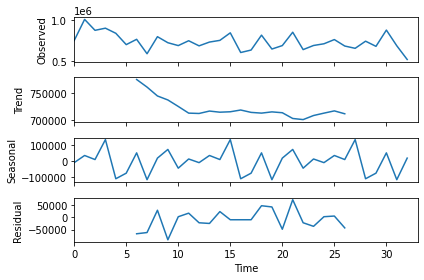

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

store_0 = time_series(resample_df, 0)
# STL 분해
stl = seasonal_decompose(store_0.values, freq=12)
stl.plot()
plt.show()

1. 과측된 실제 매출액
2. 추세, 계절성, 나머지 성분으로 분해한 것
=> 실제 관측값 = 추세 + 계절성 + 나머지 성분

3. 분해하는 이유: 매출의 전반적인 트렌드,계절성 등을 고려해야 정확한 모델을 만들 수 있어서

In [62]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()
stlm = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = stlm(ts, s.window="periodic", method='ets') # STL 분해 후 지수평활법을 통한 예측 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r을 파이썬에서 사용 가능
stlm = robjects.r(stlm)# str 형식으로 정의된 stlm
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

final_pred = []

for i in tqdm(resample_data.store_id.unique()):
    store = resample_data[resample_data['store_id']==i]
    data_len = len(store)
    print(data_len)
    
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    # STL 분해를 적용한 지수평활 model
    # if data_len > 24: # stlm() 함수는 STL 분해를 적용할 때 최소 2시즌 (24개월)보다 많은 데이터를 요구해서
    forecast = stlm(train)
    # 지수평활 model
    # else:
    #     forecast = ets(train)    # 3개월 매출을 합산, final_pred에 추가
    final_pred.append(np.sum(ro.conversion.rpy2py(forecast).values))

  0%|          | 0/516 [00:00<?, ?it/s]R[write to console]: Error in if (ncol(x) == 1L) { : missing value where TRUE/FALSE needed

  0%|          | 0/516 [00:00<?, ?it/s]

33


RRuntimeError: ignored

In [65]:
ncol(x) == 1

NameError: ignored

# 성능 향상을 위한 방법
1. 데이터 전처리
2. 여러 모델을 결합해서 예측을 시도하는 앙상블

In [68]:
# 1. 상점 매출액의 로그 정규화: 매출액의 작은 변동을 안정화해서 더 큰 트렌드 파악

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log')# 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

# 0번 상점 추출
store_0 = resample_df[resample_df['store_id']==0]
start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월

# train, test 분리
train = store_0[store_0.index <= len(store_0)-4]
test = store_0[store_0.index > len(store_0)-4]

# R의 ts 함수로 r의 time series 자료형으로 변환
train_log = ts(log(train['amount']), start=c(start_year, start_month), frequency=12) # log 정규화 
train = ts(train['amount'], start=c(start_year, start_month), frequency=12) # log 정규화를 하지 않음

# model arima
forecast_log = auto_arima(train_log)
forecast = auto_arima(train)

# pred
pred_log = np.sum(ro.conversion.rpy2py(exp(forecast_log)).values) #로그 역변환 후 3개월 합산 
pred = np.sum(ro.conversion.rpy2py(forecast).values) #3개월 매출을 합산

# test(2018-12~2019-02)
test = np.sum(test['amount'])

# mae
print('log-regularization mae: ', abs(test-pred_log))
print('mae:', abs(test-pred))

log-regularization mae:  2355.8193275395315
mae: 5817.007821156178


로그 변환한 데이터의 mae가 더 작다.
변동계수: 표준편차/평균


In [69]:
# 매출 변동 계수를 구하는 함수
def coefficient_variation(df, i):
    cv_data = df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv = cv_data[i]
    return cv

In [81]:
for i in tqdm(resample_data.store_id.unique()):
    store = resample_data[resample_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    if i == 333:
      cv = coefficient_variation(resample_data, i)
      print(cv)

100%|██████████| 516/516 [00:00<00:00, 800.30it/s]

0.16239432225540212


In [73]:

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

final_pred = []

for i in tqdm(resample_data.store_id.unique()):
    store = resample_data[resample_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    cv = coefficient_variation(resample_data, i)
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12) 
        # ets model
        forecast_log = ets(train_log)
        final_pred.append(np.sum(ro.conversion.rpy2py(exp(forecast_log)).values))
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
        # 지수평활법
        forecast = ets(train)
        final_pred.append(np.sum(ro.conversion.rpy2py(forecast).values)) 

 79%|███████▉  | 410/516 [00:09<00:02, 42.75it/s]R[write to console]: Error in ets(ts) : No model able to be fitted

 80%|███████▉  | 411/516 [00:09<00:02, 43.81it/s]


RRuntimeError: ignored

In [84]:

hybridModel = """
    function(ts){
        library(forecast)
        library(forecastHybrid)
        d_params=ndiffs(ts)
        hb_mdl<-hybridModel(ts, models="aes", # auto_arima, ets, stlm
                        a.arg=list(max.p=2, d=d_params), # auto_arima parameter
                        weight="equal") # 가중치를 동일하게 줌(평균)
        forecasted_data<-forecast(hb_mdl, h=3) # 이후 3개월(h=3)을 예측
        outdf<-data.frame(forecasted_data$mean)
        colnames(outdf)<-c('amount')
        outdf
    }
""" 

# r() 함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

final_pred = []

for i in tqdm(resample_data.store_id.unique()):
    store = resample_data[resample_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    if i == 411:
      pass
    else:
      cv = coefficient_variation(resample_data, i)
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
      if cv < 0.3:
          train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12) 
          # 앙상블 예측
          forecast_log = hybridModel(train_log)
          final_pred.append(np.sum(ro.conversion.rpy2py(exp(forecast_log)).values)) 
      # 매출액 변동 계수가 0.3 이상인 경우
      else:
          train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
          # 앙상블 예측
          forecast = hybridModel(train)
          final_pred.append(np.sum(ro.conversion.rpy2py(forecast).values))# 2. 앙상블

  # 411번째 error 

  0%|          | 0/516 [00:00<?, ?it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  0%|          | 1/516 [00:00<01:46,  4.82it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  0%|          | 2/516 [00:00<02:08,  4.00it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  1%|          | 3/516 [00:00<02:08,  3.98it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  1%|          | 4/516 [00:00<01:49,  4.66it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  1%|          | 5/516 [00:01<01:40,  5.10it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  1%|          | 6/516 [00:01<01:27,  5.83it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  1%|▏        

RRuntimeError: ignored